In [9]:
!pip install transformers torch torchvision

In [10]:
import os
import pandas as pd
import numpy as np
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [13]:
model_name = 'google/vit-base-patch16-224'
model = ViTForImageClassification.from_pretrained(model_name).to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [14]:
dataset_path = '/content/drive/MyDrive/TER/Medical_Waste_4.0_Previous_group'  # Update this path to your dataset folder

# Create a transformation pipeline
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load the dataset
dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


In [15]:
known_classes = dataset.classes  # This assumes folders are named after classes

def predict_images(images, labels):
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_indices = predictions.argmax(-1)
    predicted_labels = [model.config.id2label[idx] if model.config.id2label[idx] in known_classes else 'false_prediction' for idx in predicted_indices.cpu().numpy()]
    return predicted_labels, [known_classes[label] for label in labels.numpy()]


In [16]:
results = {'Image Path': [], 'Actual Class': [], 'Predicted Class': []}

for images, labels in dataloader:
    predicted_labels, actual_labels = predict_images(images, labels)
    results['Image Path'].extend([dataset.imgs[idx][0] for idx in range(len(images))])
    results['Actual Class'].extend(actual_labels)
    results['Predicted Class'].extend(predicted_labels)

results_df = pd.DataFrame(results)
results_df.to_csv('/content/drive/MyDrive/TER/vit-predictions-not-finetuned', index=False)
print("Results saved to predictions.csv")


Results saved to predictions.csv


In [17]:
data_path = '/content/drive/MyDrive/TER/vit-predictions-not-finetuned.csv'
results_df = pd.read_csv(data_path)

In [18]:
actual_class = results_df["Actual Class"].values
predicted_class = results_df["Predicted Class"].values

# Check if all predicted classes are "false_prediction"
all_predicted_false = all(prediction == "false_prediction" for prediction in predicted_class)

# Calculate accuracy
accuracy = accuracy_score(actual_class, predicted_class)
print("Accuracy:", accuracy)

# Calculate loss (Cross-Entropy Loss)
if all_predicted_false:
    # If all predicted classes are "false_prediction", assign equal probabilities to all classes
    num_samples = len(actual_class)
    num_classes = len(np.unique(actual_class))
    equal_probabilities = np.ones((num_samples, num_classes)) / num_classes
    loss = log_loss(actual_class, equal_probabilities)
else:
    # Otherwise, calculate loss as usual
    loss = log_loss(actual_class, predicted_class)
print("Loss:", loss)

Accuracy: 0.0
Loss: 2.564949357461536


['gauze', 'glove_pair_latex', 'glove_pair_nitrile', 'glove_pair_surgery', 'glove_single_latex', 'glove_single_nitrile', 'glove_single_surgery', 'medical_cap', 'medical_glasses', 'shoe_cover_pair', 'shoe_cover_single', 'test_tube', 'urine_bag', 'false_prediction']


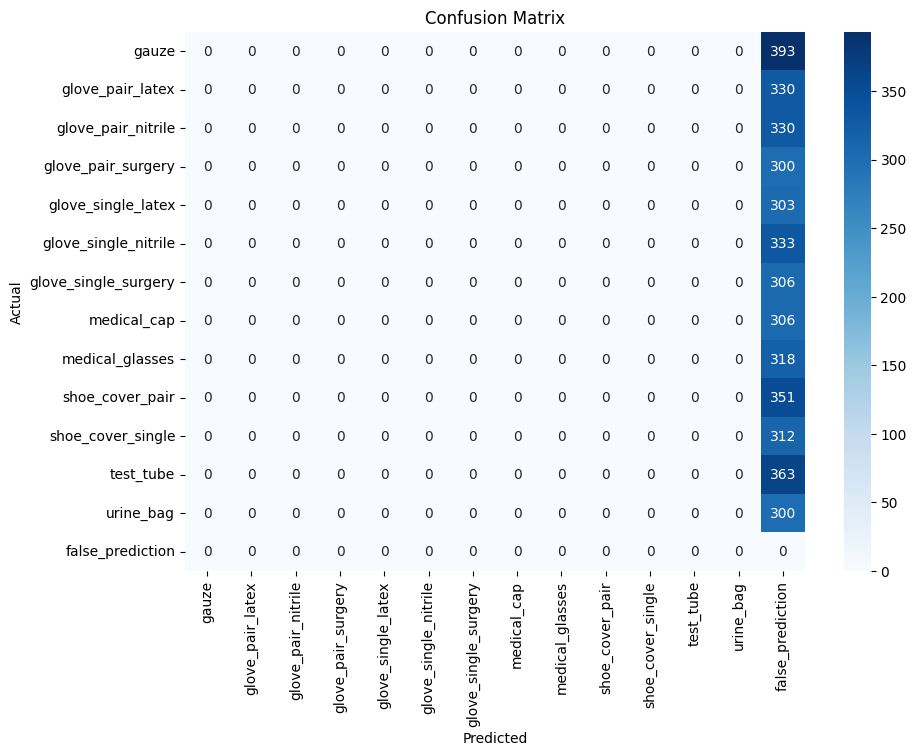

In [19]:
# Get unique classes from both actual and predicted classes
union_classes = sorted(set(results_df['Actual Class']).union(set(results_df['Predicted Class'])))
classes = union_classes[1:] + [union_classes[0]]
print(classes)

# Create confusion matrix
cm = confusion_matrix(results_df['Actual Class'], results_df['Predicted Class'], labels=classes)

# Convert confusion matrix to DataFrame for visualization
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()